### Package import and Data Loading

In [1]:
# !git clone https://github.com/fedighanmi/The-Effect-of-BatchNorm-on-NN.git
# %cd The-Effect-of-BatchNorm-on-NN

Cloning into 'The-Effect-of-BatchNorm-on-NN'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 21 (delta 6), reused 14 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (21/21), 364.30 KiB | 2.66 MiB/s, done.
Resolving deltas: 100% (6/6), done.
/content/The-Effect-of-BatchNorm-on-NN


In [6]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import torch
import random
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from utils import *

100%|██████████| 9.91M/9.91M [00:00<00:00, 22.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 619kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.65MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.90MB/s]


torch.Size([64, 1, 28, 28]) torch.Size([64])


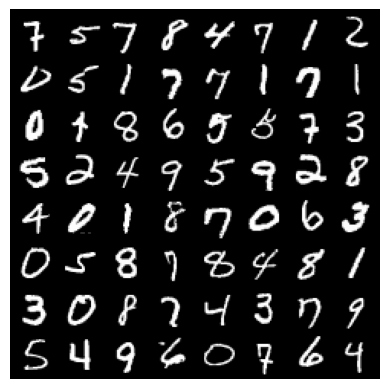

In [3]:
# 2. Data loading
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

x, y = next(iter(train_loader))
print(x.shape, y.shape)

npimg = torchvision.utils.make_grid(x).numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.axis('off')
plt.show()

### Model Definition, Running and Results:

In [4]:
# Hyperparameters
batch_size = 64
learning_rate = 0.01
epochs = 5

# Define model, loss and optimizer

class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.net(x)



class NN_BN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.net(x)

criterion = nn.CrossEntropyLoss()

model_no_bn = NN()
optimizer_1 = optim.Adam(model_no_bn.parameters(), lr=learning_rate)

model_bn = NN_BN()
optimizer_2 = optim.Adam(model_bn.parameters(), lr=learning_rate)


In [8]:
# Train model without BatchNorm with Adam
loss_no_bn, acc_no_bn = train_model(model_no_bn, optimizer_1, criterion,
                                    train_loader, test_loader, epochs)

In [9]:
# Train model with BatchNorm with Adam
loss_bn, acc_bn = train_model(model_bn, optimizer_2, criterion, train_loader, test_loader, epochs)


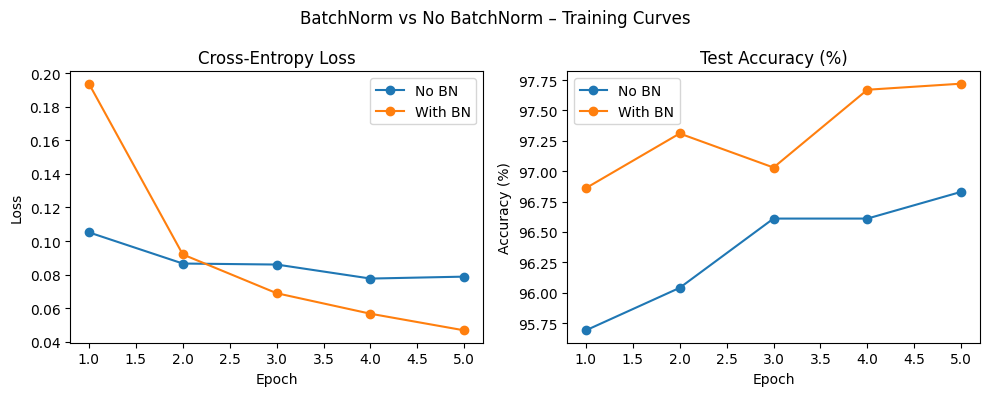

In [10]:
plot_compare_training_curves(
    loss_bn=loss_bn,
    loss_no_bn=loss_no_bn,
    acc_bn=acc_bn,
    acc_no_bn=acc_no_bn,
    epochs=epochs
)


In [11]:
# Get full test dataset as tensors (no DataLoader batching)
test_images = test_dataset.data.float() / 255.0  # shape [10000, 28, 28]
test_labels = test_dataset.targets

# Pick 10 random but *fixed* indices
fixed_indices = random.sample(range(len(test_dataset)), 30)

# Optional: if you want truly reproducible runs, fix the seed
# torch.manual_seed(0)
# random.seed(0)

# Extract the fixed examples
fixed_x = test_images[fixed_indices]
fixed_y = test_labels[fixed_indices]

# Add channel dimension (for model input)
fixed_x = fixed_x.unsqueeze(1)  # [10, 1, 28, 28]

print("Fixed sample indices:", fixed_indices)


Fixed sample indices: [8825, 2315, 6312, 5043, 8872, 2806, 678, 3180, 8722, 1383, 3477, 4788, 4588, 1208, 2803, 7673, 2134, 6200, 7016, 5521, 7766, 8097, 7201, 4851, 2547, 4804, 3077, 7074, 4349, 6584]


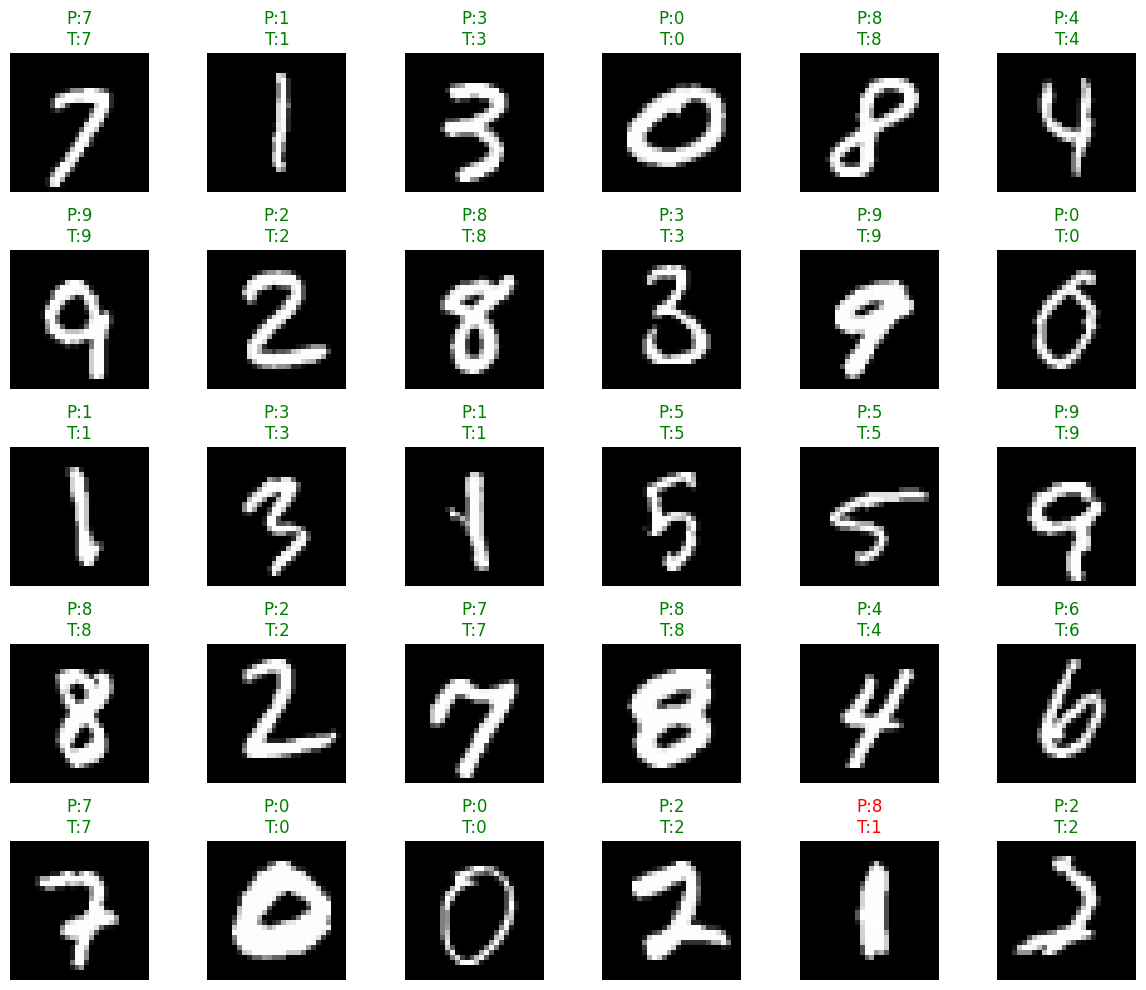

In [12]:
# Show prediction result for non normalized model
show_fixed_predictions(model_no_bn, fixed_x, fixed_y)


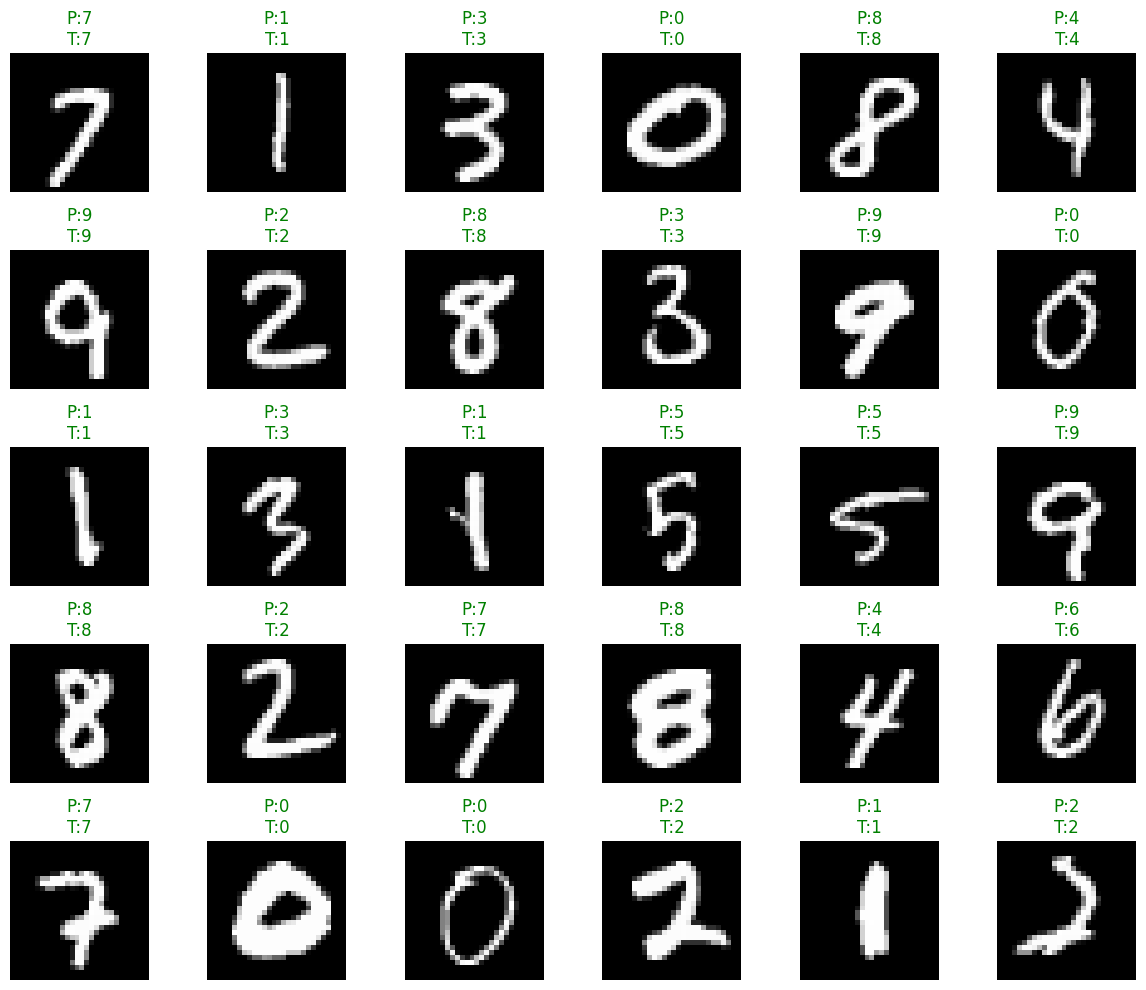

In [13]:
# Show prediction result for Batch normalized model
show_fixed_predictions(model_bn, fixed_x, fixed_y)


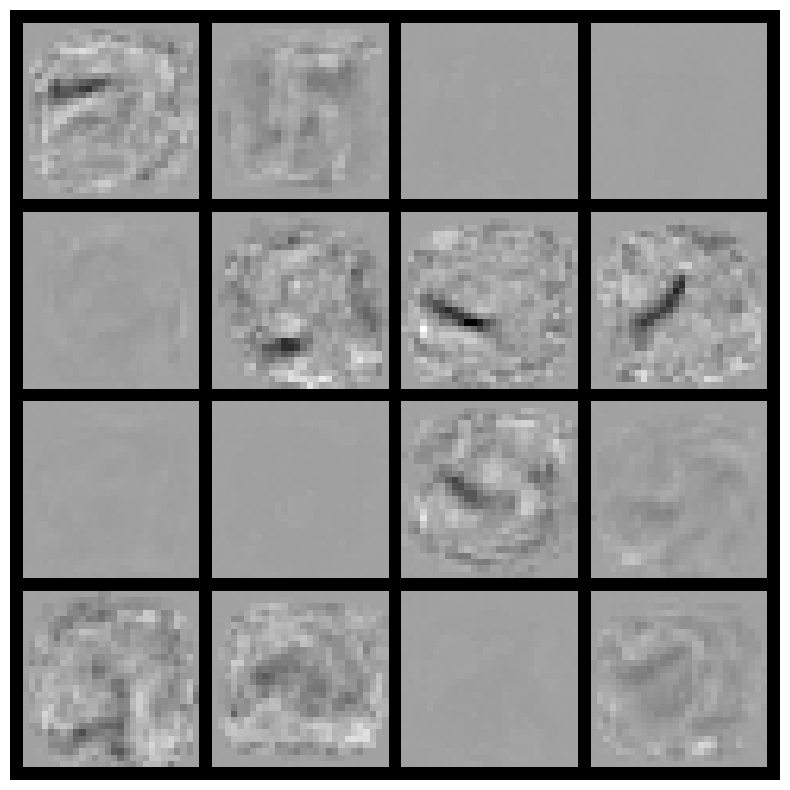

In [14]:
# Visualize linear weights for Non normalized model
visualize_linear1_weights_2d(model_no_bn, input_shape=(1, 28, 28))


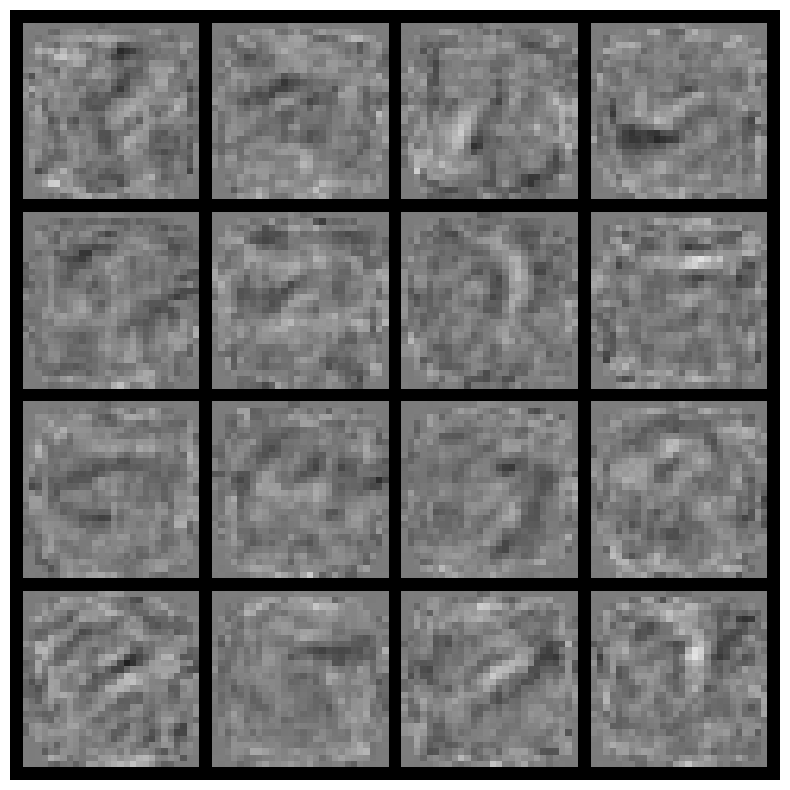

In [15]:
# Visualize linear weights for Batch normalized model
visualize_linear1_weights_2d(model_bn, input_shape=(1, 28, 28))
